# 피터와 늑대: 강화 학습 입문

이 튜토리얼에서는 경로 탐색 문제에 강화 학습을 적용하는 방법을 배워봅니다. 설정은 러시아 작곡가 [세르게이 프로코피예프](https://en.wikipedia.org/wiki/Sergei_Prokofiev)의 음악 동화 [피터와 늑대](https://en.wikipedia.org/wiki/Peter_and_the_Wolf)에서 영감을 받았습니다. 이 이야기는 어린 개척자 피터가 용감하게 집을 나와 숲의 공터로 가서 늑대를 쫓는 이야기입니다. 우리는 피터가 주변 지역을 탐험하고 최적의 내비게이션 지도를 구축할 수 있도록 돕는 머신 러닝 알고리즘을 훈련시킬 것입니다.

먼저, 유용한 라이브러리들을 가져와 봅시다:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## 강화 학습 개요

**강화 학습**(Reinforcement Learning, RL)은 **환경**에서 **에이전트**의 최적 행동을 학습하기 위해 여러 실험을 실행하는 학습 기법입니다. 이 환경 속 에이전트는 **보상 함수**로 정의된 **목표**를 가져야 합니다.

## 환경

간단히 말해, 피터의 세계를 `width` x `height` 크기의 정사각형 보드로 생각해 봅시다. 이 보드의 각 셀은 다음 중 하나일 수 있습니다:
* **땅** - 피터와 다른 생명체가 걸을 수 있는 곳
* **물** - 당연히 걸을 수 없는 곳
* **나무** 또는 **풀** - 휴식을 취할 수 있는 장소
* **사과** - 피터가 자신을 먹이기 위해 찾으면 기뻐할 만한 것
* **늑대** - 위험하므로 피해야 할 존재

환경을 다루기 위해 우리는 `Board`라는 클래스를 정의할 것입니다. 이 노트북이 너무 복잡해지지 않도록, 보드와 관련된 모든 코드는 별도의 `rlboard` 모듈로 옮겨 두었습니다. 이제 이 모듈을 가져올 것입니다. 구현의 내부 세부 사항을 더 알고 싶다면 이 모듈 내부를 살펴보세요.


In [2]:
from rlboard import *

이제 무작위 보드를 만들어보고 어떻게 보이는지 확인해봅시다:


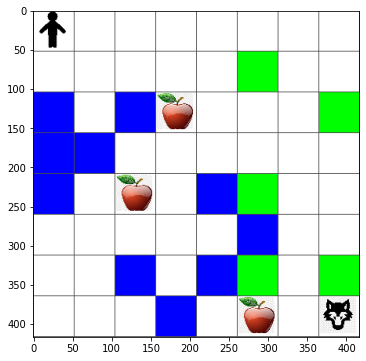

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## 행동과 정책

우리의 예시에서, 피터의 목표는 사과를 찾는 것이며, 늑대와 다른 장애물을 피하는 것입니다. 이를 위해 그는 사과를 찾을 때까지 주변을 걸어 다닐 수 있습니다. 따라서, 그는 어떤 위치에서든 다음 행동 중 하나를 선택할 수 있습니다: 위, 아래, 왼쪽, 오른쪽. 우리는 이러한 행동을 사전(dictionary)으로 정의하고, 해당 행동을 좌표 변화 쌍에 매핑할 것입니다. 예를 들어, 오른쪽으로 이동하기(`R`)는 `(1,0)` 쌍에 해당합니다.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

우리 에이전트(Peter)의 전략은 **정책(policy)**이라고 불리는 것으로 정의됩니다. 가장 간단한 정책인 **랜덤 워크(random walk)**를 살펴보겠습니다.

## 랜덤 워크

먼저 랜덤 워크 전략을 구현하여 문제를 해결해 봅시다.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

랜덤 워크 실험을 여러 번 실행하고 평균적으로 소요된 걸음 수를 확인해 봅시다:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## 보상 함수

정책을 더 똑똑하게 만들기 위해서는 어떤 움직임이 다른 움직임보다 "더 나은지"를 이해해야 합니다.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-러닝

Q-테이블 또는 다차원 배열을 만듭니다. 우리의 보드가 `width` x `height` 크기를 가지므로, Q-테이블은 `width` x `height` x `len(actions)` 형태의 numpy 배열로 표현할 수 있습니다:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Q-테이블을 보드에 시각화하기 위해 plot 함수에 전달하세요:


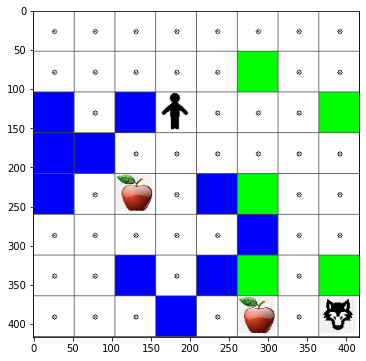

In [9]:
m.plot(Q)

## Q-러닝의 본질: 벨만 방정식과 학습 알고리즘

우리의 학습 알고리즘을 위한 의사 코드 작성:

* 모든 상태와 행동에 대해 동일한 값으로 Q-테이블 Q 초기화
* 학습률 $\alpha\leftarrow 1$ 설정
* 시뮬레이션을 여러 번 반복
   1. 랜덤 위치에서 시작
   1. 반복
        1. 상태 $s$에서 행동 $a$ 선택
        2. 행동을 실행하여 새로운 상태 $s'$로 이동
        3. 게임 종료 조건에 도달하거나 총 보상이 너무 작으면 시뮬레이션 종료  
        4. 새로운 상태에서 보상 $r$ 계산
        5. 벨만 방정식에 따라 Q-함수 업데이트: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. 총 보상을 업데이트하고 $\alpha$ 감소.

## 탐색 vs. 활용

최적의 접근법은 탐색과 활용 사이의 균형을 유지하는 것입니다. 환경에 대해 더 많이 학습할수록 최적의 경로를 따를 가능성이 높아지지만, 가끔씩은 탐색되지 않은 경로를 선택하는 것이 좋습니다.

## Python 구현

이제 학습 알고리즘을 구현할 준비가 되었습니다. 그 전에, Q-테이블의 임의의 숫자를 해당 행동에 대한 확률 벡터로 변환하는 함수가 필요합니다:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

우리는 벡터의 모든 구성 요소가 동일한 초기 상황에서 0으로 나누는 것을 방지하기 위해 원래 벡터에 소량의 `eps`를 추가합니다.

실제 학습 알고리즘은 **에포크(epochs)**라고도 불리는 5000번의 실험을 실행합니다:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

이 알고리즘을 실행한 후, Q-테이블은 각 단계에서 다양한 행동의 매력을 정의하는 값들로 업데이트되어야 합니다. 여기에서 테이블을 시각화하십시오:


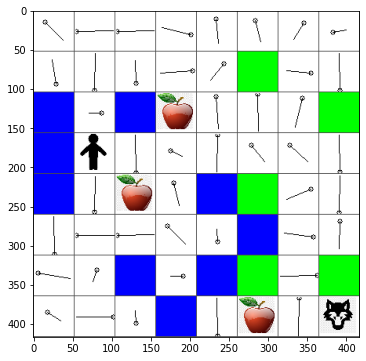

In [12]:
m.plot(Q)

## 정책 확인하기

Q-Table은 각 상태에서 각 행동의 "매력도"를 나열하기 때문에, 이를 사용하여 우리 세계에서 효율적인 이동 경로를 정의하는 것은 매우 간단합니다. 가장 간단한 경우, Q-Table 값이 가장 높은 행동을 선택하면 됩니다:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

위의 코드를 여러 번 실행해보면, 가끔 코드가 멈추는 것처럼 보이고, 노트북에서 중지 버튼을 눌러 중단해야 할 때가 있다는 것을 알 수 있습니다.

> **작업 1:** `walk` 함수에 경로의 최대 길이를 특정 단계 수(예: 100)로 제한하도록 수정하고, 위 코드가 이 값을 가끔 반환하는지 확인하세요.

> **작업 2:** `walk` 함수가 이전에 이미 방문한 장소로 돌아가지 않도록 수정하세요. 이렇게 하면 `walk`가 루프에 빠지는 것을 방지할 수 있지만, 에이전트가 탈출할 수 없는 위치에 "갇히는" 상황은 여전히 발생할 수 있습니다.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


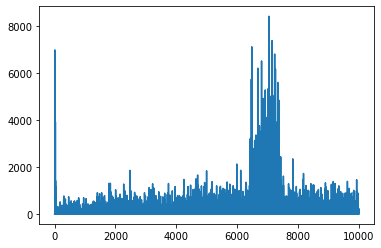

In [15]:
plt.plot(lpath)

처음에는 평균 경로 길이가 증가하는 것을 볼 수 있습니다. 이는 환경에 대해 아무것도 모를 때, 나쁜 상태나 물, 늑대에 갇히기 쉽기 때문일 가능성이 높습니다. 환경에 대한 지식을 더 많이 배우고 이를 활용하기 시작하면 더 오래 탐험할 수 있지만, 여전히 사과가 어디에 있는지 잘 모르는 상태입니다.

충분히 학습한 후에는 에이전트가 목표를 달성하기가 더 쉬워지고, 경로 길이가 줄어들기 시작합니다. 하지만 여전히 탐험을 계속하기 때문에 최적의 경로에서 벗어나 새로운 옵션을 탐색하며 경로가 최적보다 길어지는 경우가 자주 발생합니다.

또한 이 그래프에서 관찰할 수 있는 것은, 어느 시점에서 경로 길이가 갑자기 증가했다는 점입니다. 이는 과정의 확률적 특성을 나타내며, 새로운 값으로 Q-Table 계수를 덮어쓰면서 "망칠" 수 있다는 것을 보여줍니다. 이를 최소화하려면 학습률을 줄이는 것이 이상적입니다(즉, 훈련이 끝날 무렵에는 Q-Table 값을 작은 값으로만 조정해야 합니다).

전반적으로, 학습 과정의 성공과 품질은 학습률, 학습률 감소, 할인 계수와 같은 매개변수에 크게 의존한다는 점을 기억하는 것이 중요합니다. 이러한 매개변수는 **하이퍼파라미터**라고 불리며, 훈련 중에 최적화하는 **파라미터**(예: Q-Table 계수)와 구별됩니다. 최적의 하이퍼파라미터 값을 찾는 과정을 **하이퍼파라미터 최적화**라고 하며, 이는 별도의 주제로 다룰 가치가 있습니다.


## 연습 문제
#### 더 현실적인 '피터와 늑대' 세계

우리의 상황에서 피터는 거의 지치거나 배고프지 않은 상태로 자유롭게 이동할 수 있었습니다. 하지만 더 현실적인 세계에서는 피터가 가끔씩 앉아서 쉬어야 하고, 스스로 먹을 것도 챙겨야 합니다. 다음 규칙들을 구현하여 우리의 세계를 더 현실적으로 만들어 봅시다:

1. 한 장소에서 다른 장소로 이동할 때, 피터는 **에너지**를 잃고 약간의 **피로**를 얻게 됩니다.
2. 피터는 사과를 먹음으로써 에너지를 얻을 수 있습니다.
3. 피터는 나무 아래나 풀밭에서 쉬면서 피로를 해소할 수 있습니다 (즉, 나무나 풀이 있는 보드 위치 - 초록색 필드로 이동).
4. 피터는 늑대를 찾아내고 처치해야 합니다.
5. 늑대를 처치하려면, 피터는 특정 수준의 에너지와 피로 상태를 유지해야 하며, 그렇지 않으면 전투에서 패배합니다.

위의 규칙에 따라 보상 함수를 수정하고, 강화 학습 알고리즘을 실행하여 게임에서 승리하기 위한 최적의 전략을 학습하세요. 그리고 무작위 이동(random walk)과 알고리즘의 결과를 비교하여, 승리와 패배 횟수를 분석해 보세요.

> **Note**: 하이퍼파라미터를 조정해야 할 수도 있습니다. 특히 에포크(epoch) 수를 조정해야 할 가능성이 큽니다. 게임의 성공(늑대와의 전투)은 드문 이벤트이기 때문에, 더 긴 훈련 시간이 필요할 수 있습니다.



---

**면책 조항**:  
이 문서는 AI 번역 서비스 [Co-op Translator](https://github.com/Azure/co-op-translator)를 사용하여 번역되었습니다. 정확성을 위해 최선을 다하고 있으나, 자동 번역에는 오류나 부정확성이 포함될 수 있습니다. 원본 문서를 해당 언어로 작성된 상태에서 권위 있는 자료로 간주해야 합니다. 중요한 정보의 경우, 전문적인 인간 번역을 권장합니다. 이 번역 사용으로 인해 발생하는 오해나 잘못된 해석에 대해 당사는 책임을 지지 않습니다.  
